In [12]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
os.chdir(".")
from parc.data.data import EnergeticMatDataPipeLine as EmData
#from parc import misc, metrics, visualization
from parc.model import model_em as model


# Data pipeline

In [13]:
# Get data and normalization
state_seq_whole, vel_seq_whole = EmData.clip_raw_data(idx_range = (0,150))
state_seq_norm = EmData.data_normalization(state_seq_whole,3)
vel_seq_norm = EmData.data_normalization(vel_seq_whole,2)

void_2
void_5
void_7
void_13
void_14
void_15
void_16
void_17
void_18
void_19
void_20
void_21
void_22
void_23
void_26
void_28
void_29
void_30
void_31
void_32
void_33
void_35
void_36
void_37
void_38
void_39
void_40
void_41
void_42
void_43
void_46
void_50
void_51
void_52
void_53
void_54
void_55
void_56
void_57
void_60
void_61
void_62
void_63
void_64
void_65
void_66
void_67
void_69
void_70
void_71
void_72
void_73
void_74
void_75
void_81
void_82
void_87
void_100
void_101
void_102
void_103
void_104
void_105
void_106
void_107
void_108
void_109
void_110
void_111
void_112
void_113
void_114
void_115
void_117
void_118
void_119
void_120
void_122
void_123
void_124
void_125
void_126
void_127
void_128
void_129
void_130
void_131
void_133
void_134
void_135
void_136
void_137
void_138
void_139
void_140
void_141
void_142
void_143
void_146
void_147


# Training


### Stage 1: Differentiator training

In [14]:
# Create tf.dataset
dataset_input = tf.data.Dataset.from_tensor_slices((state_seq_norm[0][:,:,:,:3],vel_seq_norm[0][:,:,:,:2]))
dataset_label = tf.data.Dataset.from_tensor_slices((state_seq_norm[0][:,:,:,-3:],vel_seq_norm[0][:,:,:,-2:]))
dataset = tf.data.Dataset.zip((dataset_input, dataset_label))
dataset = dataset.shuffle(buffer_size = 2192) 
dataset = dataset.batch(8)

In [ ]:
tf.keras.backend.clear_session()
parc = model.PARCv2(n_state_var = 3, n_time_step = 1, step_size= 1/15, solver = "rk4", mode = "differentiator_training")
# parc.differentiator.load_weights('parc2_diff_rk4.h5')
parc.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001, beta_1 = 0.9, beta_2 = 0.999))
parc.fit(dataset, epochs = 50, shuffle = True)

In [ ]:
parc.differentiator.save_weights('test_parc2_diff_rk4.h5')

### Stage 2: Data-driven integration training

In [4]:
# Pretrain integrator
tf.keras.backend.clear_session()
parc = model.PARCv2(n_state_var = 3, n_time_step = 1, step_size= 1/15, solver = "rk4", mode = "integrator_training")
parc.differentiator.load_weights('./test_parc2_diff_rk4.h5')
parc.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001, beta_1 = 0.9, beta_2 = 0.999))
parc.fit(dataset, epochs = 50, shuffle = True)

Epoch 1/50


2024-02-15 16:03:10.794010: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2024-02-15 16:03:15.019531: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fc0b0927fe0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-15 16:03:15.019571: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2024-02-15 16:03:15.127902: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-15 16:03:15.978909: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


274/274 [==============================] - 227s 667ms/step - total_loss: 21188.9082
Epoch 2/50
274/274 [==============================] - 183s 666ms/step - total_loss: 1279.4615
Epoch 3/50
274/274 [==============================] - 182s 666ms/step - total_loss: 960.0252
Epoch 4/50
274/274 [==============================] - 183s 667ms/step - total_loss: 842.9512
Epoch 5/50
274/274 [==============================] - 182s 666ms/step - total_loss: 793.6264
Epoch 6/50
274/274 [==============================] - 183s 667ms/step - total_loss: 790.2280
Epoch 7/50
274/274 [==============================] - 183s 667ms/step - total_loss: 792.2332
Epoch 8/50
274/274 [==============================] - 183s 667ms/step - total_loss: 756.9833
Epoch 9/50
274/274 [==============================] - 183s 667ms/step - total_loss: 717.0280
Epoch 10/50
274/274 [==============================] - 183s 667ms/step - total_loss: 709.5921
Epoch 11/50
274/274 [==============================] - 183s 667ms/step - tota

In [5]:
parc.integrator.save_weights('test_parc2_int_rk4.h5')

In [15]:
import os
import numpy as np
import skimage
from skimage.measure import block_reduce


def clip_raw_data(idx_range, sequence_length=2, n_state_var=3, purpose = "diff_training"):
    state_seq_whole = []
    vel_seq_whole = []

    for i in range(idx_range[0],idx_range[1]):
        file_path = os.path.join(os.sep,'scratch','pdy2bw','coupled_field_with_vel', f'void_{i}.npy')
        if os.path.exists(file_path):
            raw_data = np.float32(np.load(file_path))
            data_shape = raw_data.shape
            if data_shape[2] > sequence_length:
                print(i)
                npad = ((0, abs(data_shape[0] - 512)), (0, abs(data_shape[1] - 1024)), (0, 0))
                raw_data = np.pad(raw_data, pad_width=npad, mode='edge')
                raw_data = np.expand_dims(raw_data, axis=0)
                raw_data = block_reduce(raw_data[:,:,:,:], (1,4,4,1),np.max)

                data_shape = raw_data.shape
                num_time_steps = data_shape[-1] // (n_state_var + 2)
                if purpose == "diff_training":
                    j_range = num_time_steps - sequence_length
                else:
                    j_range = 1
                state_seq_case = [np.concatenate([raw_data[:, :, :256, (j + k) * (n_state_var + 2):\
                                                        (j + k) * (n_state_var + 2) + n_state_var] \
                                                        for k in range(sequence_length)], axis=-1) \
                                                        for j in range  (j_range)] 

                vel_seq_case = [np.concatenate([raw_data[:, :, :256, (j + k) * (n_state_var + 2) +  n_state_var :\
                                                        (j + k) * (n_state_var + 2) + n_state_var + 2] \
                                                        for k in range(sequence_length)], axis=-1) \
                                                        for j in range (j_range)] 

                state_seq_whole.extend(state_seq_case)
                vel_seq_whole.extend(vel_seq_case)

    state_seq_whole = np.concatenate(state_seq_whole, axis=0)
    vel_seq_whole = np.concatenate(vel_seq_whole, axis=0)

    return state_seq_whole, vel_seq_whole

# Normalization
def data_normalization(input_data,no_of_channel):
    norm_data = np.zeros(input_data.shape)
    min_val = []
    max_val = []
    for i in range(no_of_channel):
        norm_data[:,:,:,i::no_of_channel] = ((input_data[:,:,:,i::no_of_channel] - np.amin(input_data[:,:,:,i::no_of_channel])) / (np.amax(input_data[:,:,:,i::no_of_channel]) - np.amin(input_data[:,:,:,i::no_of_channel])) + 1E-9)
        min_val.append(np.amin(input_data[:,:,:,i::no_of_channel]))
        max_val.append(np.amax(input_data[:,:,:,i::no_of_channel]))
    return norm_data, min_val, max_val

def data_normalization_test(input_data, min_val, max_val, no_of_channel):
    norm_data = np.zeros(input_data.shape)
    for i in range(no_of_channel):
        norm_data[:,:,:,i::no_of_channel] = ((input_data[:,:,:,i::no_of_channel] - min_val[i]) / (max_val[i] - min_val[i] + 1E-9))
    return norm_data

# Validation

In [16]:
state_seq_whole, vel_seq_whole = clip_raw_data(idx_range = (150,200), sequence_length = 15, n_state_var = 3, purpose = "test")
state_seq_norm_test = data_normalization_test(state_seq_whole, state_seq_norm[1], state_seq_norm[2],3)
vel_seq_norm_test = data_normalization_test(vel_seq_whole, vel_seq_norm[1], vel_seq_norm[2],2)

151
152
153
154
155
156
157
158
159
160
161
162
165
166
168
170
171
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190


## Load model

In [17]:
tf.keras.backend.clear_session()
parc_rk = model.PARCv2(n_state_var = 3, n_time_step = 14, step_size= 1/15, solver = "rk4", mode= "integrator_training")
parc_rk.compile()
parc_rk.differentiator.load_weights('test_parc2_diff_rk4.h5')
parc_rk.integrator.load_weights('test_parc2_int_rk4.h5')

In [7]:
parc_rk.save('test_parcv2_em.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_api.py:146: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  saving_lib.save_model(model, filepath)


In [18]:
def predict(inputs, parc):
    state_var_init = tf.cast(inputs[0],dtype = tf.float32)
    velocity_init = tf.cast(inputs[1], dtype = tf.float32)
    input_seq = tf.concat([state_var_init, velocity_init],axis = -1)

    input_seq_current = input_seq

    res = []
    for _ in range(parc.n_time_step):    
        input_seq_current, update = parc.explicit_update(input_seq_current)
        # if parc.use_data_driven_int == True:
        #     state_var_next, velocity_next = parc.integrator([update[:,:,:,:3],update[:,:,:,3:],input_seq_current[:,:,:,:3], input_seq_current[:,:,:,3:]])
        #     input_seq_current = tf.concat([state_var_next, velocity_next],axis = -1)

        res.append(input_seq_current)
        # res = tf.concat(res,axis = -1)
    return res

In [19]:
# Make prediction
pred_whole = []
for case_idx in range(5):
    state_var_current = state_seq_norm_test[case_idx:case_idx+1,:,:,0:3]
    velocity_current = vel_seq_norm_test[case_idx:case_idx+1,:,:,0:2]
    pred_state = predict([state_var_current,velocity_current],parc_rk)
    pred_state = np.concatenate(pred_state,axis =-1)
    pred_whole.append(pred_state)
pred = np.concatenate(pred_whole, axis = 0)

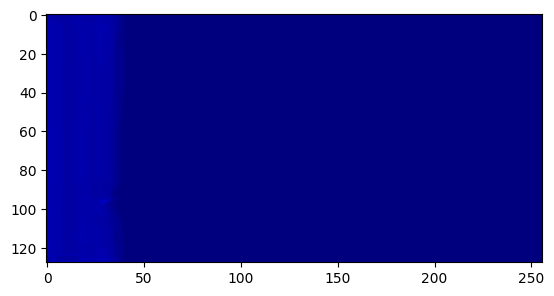

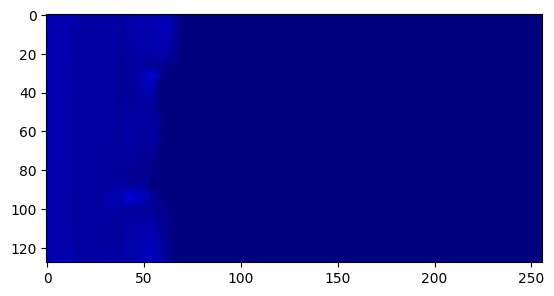

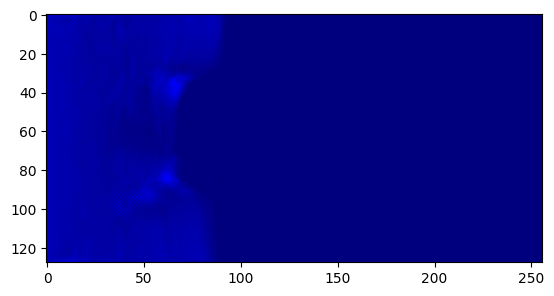

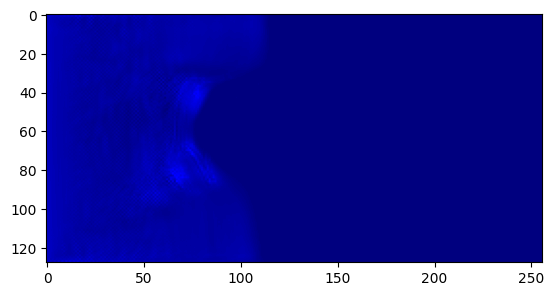

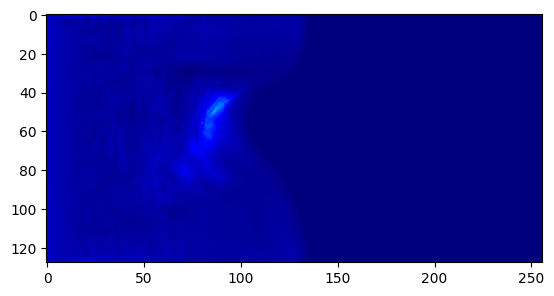

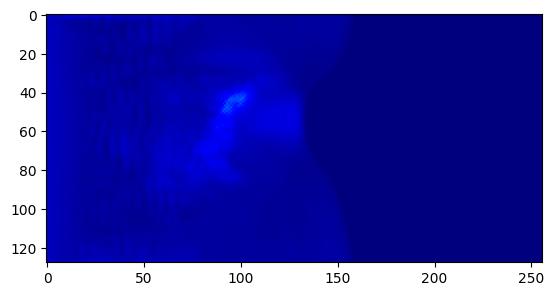

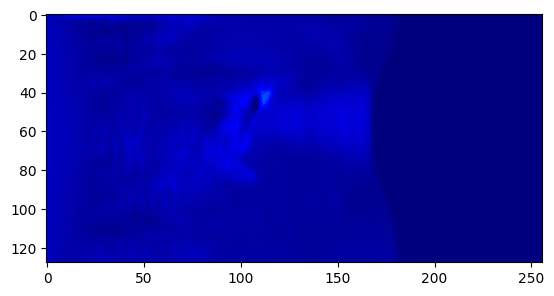

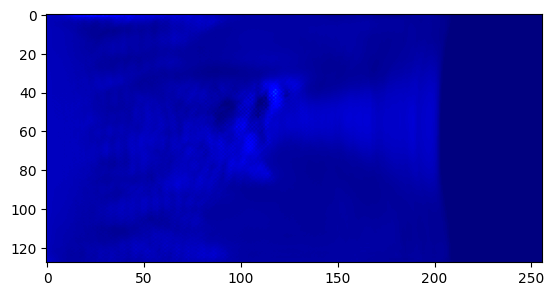

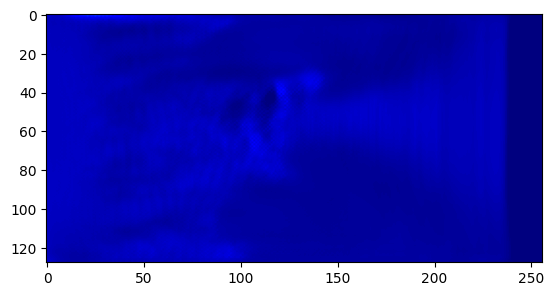

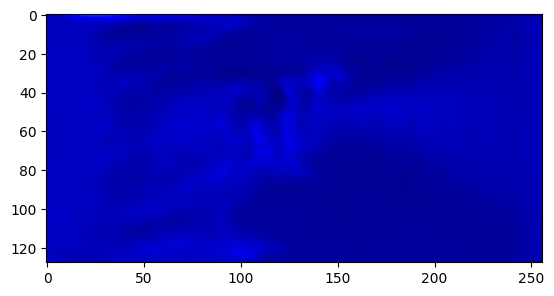

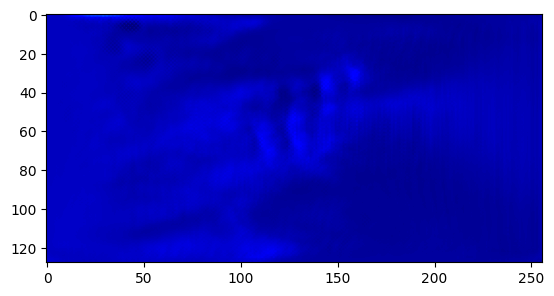

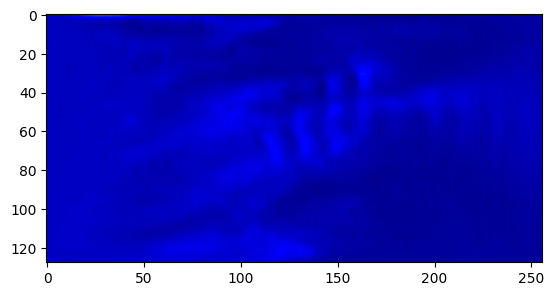

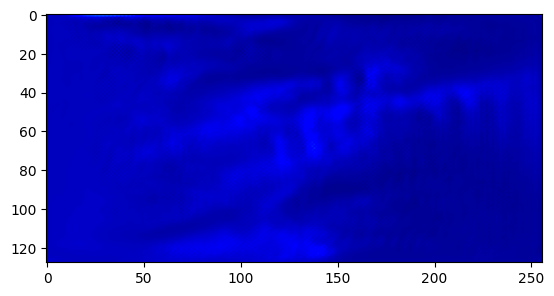

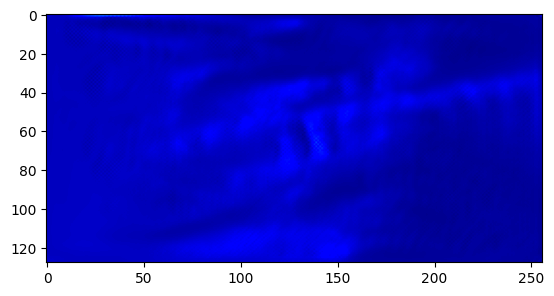

In [24]:
idx = 2
for i in range(14):
    plt.imshow(pred[idx,:,:,i*5], vmin = 0 , vmax = 1,cmap = 'jet')
    plt.show()

In [ ]:
def data_denormalization(input_data, min_val, max_val, no_of_channel):
    norm_data = np.zeros(input_data.shape)
    for i in range(no_of_channel):
        norm_data[:,:,:,i::no_of_channel] = (input_data[:,:,:,i::no_of_channel] * (max_val[i] - min_val[i] + 1E-9)) + min_val[i]
    return norm_data

In [ ]:
pred_out = data_denormalization(pred,min_val_state,max_val_state, no_of_channel = 5)

In [ ]:
np.save('./plotting/em/parcv2_em.npy',pred_out)

### Quantitative analysis

In [ ]:
state_rk = []
outlier = [0, 3, 30, 31, 32, 33, 18, 19, 11]
# outlier = []
for idx in range(34):
    if idx not in outlier:
        print(idx)
        state_var_current = state_seq_norm_test[idx:idx+1,:,:,0:3]
        velocity_current = vel_seq_norm_test[idx:idx+1,:,:,0:2]
        pred_state = parc_rk.predict([state_var_current,velocity_current])
        pred_state_case = np.concatenate(pred_state, axis = -1)
        print(pred_state_case.shape)
        state_rk.append(pred_state_case)
state_rk = np.concatenate(state_rk, axis = 0)
print(state_rk.shape)       

In [ ]:
def plot_sensitivity(y_true, y_pred_euler, y_pred_rk, metric, ts):
    """sensitivity plot comparing true and prediction
    :param y_true:  (tuple)
    :param y_pred:  (tuple)
    :param metric:  (str)   metric for plotting. {hs_temp, hs_area, rate_hs_temp, rate_hs_area}
    """

    if metric == "hs_temp" or metric == "hs_area":
        ts = np.linspace(3.16, 15.01, ts)
    elif metric == "rate_hs_temp" or metric == "rate_hs_area":
        ts = np.linspace(3.16, 14.22, ts - 1)
    else:
        print(
            "Wrong metric selection. Possible metrics are: 'hs_temp', 'hs_area', 'rate_hs_temp', 'rate_hs_area"
        )

    col_true, col_pred, col_yel = "#277DA1", "#F94144", "#F9C74F"
    plt.figure(figsize=(13, 10))

    # mean values
    plt.plot(ts, y_true[0], color=col_true, lw=2.5, label="Ground truth")
    plt.plot(ts, y_pred_rk[0], color=col_pred, lw=2.5, label="PARC-RK4")
#     plt.plot(ts, y_pred_euler[0], color=col_yel, lw=2.5, label="PARC-Euler")

    # plot intervals
    plt.fill_between(ts, y_true[1], y_true[2], color=col_true, alpha=0.2)
    plt.fill_between(ts, y_pred_rk[1], y_pred_rk[2], color=col_pred, alpha=0.2)
#     plt.fill_between(ts, y_pred_euler[1], y_pred_euler[2], color=col_yel, alpha=0.2)

    # corresponding titles and wordings based on the metric
    if metric == "hs_temp":
        plt.title(r"Ave. Hotspot Temperature ($T_{hs}$)", fontsize=32, pad=15)
        plt.xlabel(r"t ($ns$)", fontsize=28)
        plt.ylabel(r" $T_{hs}$ ($K$)", fontsize=28)
        plt.axis([3.16, 15.01, 0, 5000])
    elif metric == "hs_area":
        plt.title(r"Hotspot Area ($A_{hs}$)", fontsize=32, pad=15)
        plt.xlabel(r"t ($ns$)", fontsize=28)
        plt.ylabel(r"$A_{hs}$ ", fontsize=28)
        plt.axis([3.16, 15.01, 0, 25])
    elif metric == "rate_hs_temp":
        plt.title(
            r"Ave. Hotspot Temperature Rate of Change ($\dot{T_{hs}}$)",
            fontsize=32,
            pad=15,
        )
        plt.xlabel(r"t ($ns$)", fontsize=28)
        plt.ylabel(r"$\dot{T_{hs}}$ ($K$/$ns$)", fontsize=28)
        plt.axis([3.16, 15.01, -30, 1200])
    else:
        plt.title(r"Hotspot Area Rate of Change ($\dot{A_{hs}}$)", fontsize=32, pad=15)
        plt.xlabel(r"t ($ns$)", fontsize=28)
        plt.ylabel(r"$\dot{A_{hs}}$", fontsize=28)
        plt.axis([3.16, 15.01, 0, 10])

    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.legend(loc=2, fontsize=28)
    plt.show()


In [ ]:
## Preprocess temperature data
# Get temperature field evolution
# Temp_gt = np.delete(state_seq_norm_test, outlier, 0)
# Temp_gt = Temp_gt[:,:,:,3::3]    # Ground truth temperature field evolution
Temp_gt = state_seq_norm_test[:,:,:,3::3]    # Ground truth temperature field evolution
# Temp_gt = np.clip(Temp_gt,0,1)
Temp_pred_parc_rk = state_rk[:,:,:,0::5]   # PARC prediction temperature field evolution
Temp_pred_parc_euler = state_euler[:,:,:,0::5]   # PARC prediction temperature field evolution

# # Denormalize temperature field evolution
Temp_gt = misc.scale_temperature(temperatures = Temp_gt, start_ts = 0, max_temp = 5000, min_temp = 300)
Temp_pred_parc_rk = misc.scale_temperature(temperatures = Temp_pred_parc_rk, start_ts = 0, max_temp = 5000, min_temp = 300)
Temp_pred_parc_euler = misc.scale_temperature(temperatures = Temp_pred_parc_euler, start_ts = 0, max_temp = 5000, min_temp = 300)

# Compute sensitivity of ground truth data
gt_hs_temp, gt_hs_area = metrics.calculate_hotspot_metric(Temp_gt[:,:,:,0:], cases_range = (0,25), n_timesteps = 15)
gt_rate_hs_temp,gt_rate_hs_area = metrics.calculate_hotspot_metric_rate_of_change(Temp_gt[:,:,:,0:], cases_range = (0,25), n_timesteps = 15)

# Compute sensitivity of PARC prediction
parc_hs_temp_rk, parc_hs_area_rk = metrics.calculate_hotspot_metric(Temp_pred_parc_rk[:,:,:,0:], cases_range = (0,25), n_timesteps =15)
parc_rate_hs_temp_rk, parc_rate_hs_area_rk = metrics.calculate_hotspot_metric_rate_of_change(Temp_pred_parc_rk[:,:,:,0:], cases_range = (0,25), n_timesteps = 15)

# Compute sensitivity of PARC prediction
parc_hs_temp_euler, parc_hs_area_euler = metrics.calculate_hotspot_metric(Temp_pred_parc_euler[:,:,:,0:], cases_range = (0,25), n_timesteps =15)
parc_rate_hs_temp_euler, parc_rate_hs_area_euler = metrics.calculate_hotspot_metric_rate_of_change(Temp_pred_parc_euler[:,:,:,0:], cases_range = (0,25), n_timesteps = 15)

In [ ]:
plot_sensitivity(y_true=gt_hs_temp, y_pred_rk=parc_hs_temp_rk, y_pred_euler = parc_hs_temp_euler,  metric='hs_temp',ts=15)

In [ ]:
plot_sensitivity(y_true=gt_hs_area, y_pred_rk=parc_hs_area_rk, y_pred_euler = parc_hs_area_euler, metric='hs_area',ts=15)

In [ ]:
plot_sensitivity(y_true=gt_rate_hs_temp, y_pred_rk=parc_rate_hs_temp_rk, y_pred_euler = parc_rate_hs_temp_euler, metric='rate_hs_temp',ts=15)

In [ ]:
plot_sensitivity(y_true=gt_rate_hs_area, y_pred_rk=parc_rate_hs_area_rk, y_pred_euler = parc_rate_hs_area_euler, metric='rate_hs_area',ts=15)

In [ ]:
## Preprocess temperature data
# Get temperature field evolution
# Temp_gt = np.delete(state_seq_norm_test, outlier, 0)
# Temp_gt = Temp_gt[:,:,:,3::3]    # Ground truth temperature field evolution
P_gt = vel_seq_norm_test[:,:,:,4::3]    # Ground truth temperature field evolution
# Temp_gt = np.clip(Temp_gt,0,1)
P_pred_parc_rk = state_rk[:,:,:,1::5]   # PARC prediction temperature field evolution

# # Denormalize temperature field evolution
Temp_gt = misc.scale_temperature(temperatures = Temp_gt, start_ts = 0, max_temp = 50e9, min_temp = -2e9)
Temp_pred_parc_rk = misc.scale_temperature(temperatures = Temp_pred_parc_rk, start_ts = 0, max_temp = 50e9, min_temp = -2e9)

In [ ]:
plot_sensitivity(y_true=gt_rate_hs_area, y_pred_rk=parc_rate_hs_area_rk, y_pred_euler = parc_rate_hs_area_euler, metric='rate_hs_area',ts=15)